#### Imports

In [166]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import math
import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.utils import resample

In [167]:
df_main = pd.read_csv('Data.csv')

In [168]:
df_main.head()

,ID,Salary,DOJ,DOL,Original Designation,Designation,Domain,JobCity,Gender,DOB,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,Degree,Specialization,collegeGPA,CollegeCityID,CollegeCityTier,CollegeState,GraduationYear,English,Logical,Quant,DomainScore,ComputerProgramming,ElectronicsAndSemicon,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience
0,42418,435000.0,5/1/2010 0:00,6/1/2014 0:00,electrical engineer,electrical engineer,Engineering,Bhopal,f,10/23/1987 0:00,65.0,cbse,2005,54.0,cbse,402,1,B.Tech/B.E.,biomedical engineering,65.90,402,0,Madhya Pradesh,2010,405,425,405,0.0,0,0,0,0,0,0,0,0.9737,-0.2793,-1.2148,-0.8778,0.5024
1,214964,315000.0,8/1/2011 0:00,7/1/2012 0:00,senior software engineer,senior software engineer,Engineering,Mumbai,f,12/25/1988 0:00,88.4,cbse,2006,79.2,cbse,332,1,B.Tech/B.E.,biomedical engineering,69.54,332,0,Punjab,2011,525,705,524,0.0,0,0,0,0,0,0,0,0.9737,-0.1232,-1.0697,1.5899,0.9763
2,900218,420000.0,7/1/2010 0:00,8/1/2011 0:00,management trainee,trainee manager,Management,NCR,m,1/11/1988 0:00,82.0,cbse,2005,75.8,cbse,443,1,M.Tech./M.E.,other,82.50,443,0,Uttar Pradesh,2014,625,520,705,0.0,0,0,0,0,0,0,0,-1.8825,0.5454,-0.9122,-0.1076,-1.4356
3,220655,400000.0,6/1/2011 0:00,3/1/2013 0:00,team leader,technical lead,Management,Chandigarh,m,11/16/1989 0:00,88.2,cbse,2007,77.8,cbse,285,1,B.Tech/B.E.,chemical engineering,62.40,285,0,Punjab,2011,595,695,575,0.0,0,0,0,0,0,0,0,-1.0355,0.9688,-0.6343,-0.4078,0.0284
4,962376,700000.0,7/1/2014 0:00,NaN,product manager,product manager,Management,Jaipur,m,1/3/1992 0:00,87.4,cbse,2009,74.0,state board,436,1,M.Tech./M.E.,other,72.79,436,0,Uttarakhand,2014,625,450,655,0.0,0,0,0,0,0,0,0,-0.3027,-0.4536,-0.6048,-0.8682,0.0973


#### Data Cleansing

In [169]:
df = df_main.copy()
# Drop irrelevant columns
df.drop(['ID', 'DOJ', 'DOL','Original Designation','Designation'], axis=1, inplace=True)

# Trim all string inputs
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Encoding Gender as Binary (0 = Male, 1 = Female)
df['Gender'] = df['Gender'].apply(lambda x: 1 if x.lower() == 'f' else 0)

from datetime import datetime
today = datetime.now()


# Covering DOB to Age
df['Age'] = df['DOB'].apply(lambda x: np.round((today - datetime.strptime(x, '%m/%d/%Y %H:%M')).days / 365),0)

In [170]:
cols = ['ComputerProgramming', 'ElectronicsAndSemicon', 'ComputerScience', 'MechanicalEngg', 'ElectricalEngg', 'TelecomEngg', 'CivilEngg']
for col in cols:
    df[col] = df[col].apply(lambda x: np.nan if x == 0 else x)

df['SecScore'] = df[cols].mean(axis=1)
df['SecScore'] = df['SecScore'].apply(lambda x: -1 if math.isnan(x) else x)

for col in cols:
    df[col] = df[col].apply(lambda x: 0 if math.isnan(x) else 1)


In [171]:
df['SecScore']

0        -1.000000
1        -1.000000
2        -1.000000
3        -1.000000
4        -1.000000
5        -1.000000
6       500.000000
7       388.000000
8        -1.000000
9       388.000000
10       -1.000000
11       -1.000000
12      460.000000
13       -1.000000
14       -1.000000
15       -1.000000
16       -1.000000
17       -1.000000
18       -1.000000
19       -1.000000
20      433.000000
21       -1.000000
22       -1.000000
23      292.000000
24       -1.000000
25       -1.000000
26       -1.000000
27       -1.000000
28       -1.000000
29       -1.000000
           ...    
3958    411.666667
3959    415.500000
3960    495.500000
3961    432.333333
3962    501.500000
3963    493.666667
3964    553.000000
3965    449.000000
3966    449.000000
3967    504.000000
3968    443.000000
3969    489.333333
3970    580.000000
3971    487.500000
3972    492.500000
3973    390.333333
3974    564.000000
3975    596.000000
3976    379.333333
3977    432.000000
3978    606.000000
3979    459.

In [172]:
# Rename columns
df = df.rename(columns={'conscientiousness': 'Conscientiousness',
                        'agreeableness': 'Agreeableness',
                        'extraversion': 'Extraversion',
                        'nueroticism': 'Nueroticism',
                        'openess_to_experience': 'OTE'})

# Create 1-hot features for categorical variables
df = pd.concat([df, pd.get_dummies(df['Degree'])], axis=1)
#df = pd.concat([df, pd.get_dummies(df['CollegeState'])], axis=1)

# Filter for top 20 cities based on the number of records. Some cities have only 1 record and this is done to limit the outliers
df = df[df.JobCity.isin(list(df.groupby(['JobCity']).size().nlargest(20).reset_index(drop=False)['JobCity']))]
#df = pd.concat([df, pd.get_dummies(df['JobCity'])], axis=1)
degree = df['Degree'].astype('category')
#degree_val = dict(enumerate(degree.cat.categories))
# Drop irrelevant columns
df.drop(['JobCity', 'DOB', 'CollegeState', '10board', '12graduation', '12board', 'CollegeID', 'CollegeCityID', 'CollegeCityTier'], axis=1, inplace=True)

# Create EECS as a combined specialization
df['Specialization'] = df['Specialization'].apply(lambda x: 'Other Specialization' if x.lower() == 'other' else x)
df['Specialization'] = df['Specialization'].apply(lambda x: 'Electrical Engineering & Computer Science' if x in ['electronics engineering', 'electrical engineering', 'computer science'] else x)
df['Specialization'] = df['Specialization'].apply(lambda x: x.title())
df = pd.concat([df, pd.get_dummies(df['Specialization'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['Domain'])], axis=1)
domains = df['Domain'].astype('category')
specializations = df['Specialization'].astype('category')

#df.drop(['Specialization', 'Domain'], axis=1, inplace=True)

In [173]:
# Create salary buckets and drop records for salary less than 1L
X = df
df.head(10)
domains.head(10)
domains_val

{0: 'Business',
 1: 'Education',
 2: 'Engineering',
 3: 'Finance',
 4: 'HR',
 5: 'Management',
 6: 'Marketing',
 7: 'Operations',
 8: 'QA',
 9: 'Research',
 10: 'Sales',
 11: 'Support',
 12: 'Tech',
 13: 'UX/UI Design'}

In [174]:
for val in X.columns:
    print(val)

Salary
Domain
Gender
10percentage
12percentage
CollegeTier
Degree
Specialization
collegeGPA
GraduationYear
English
Logical
Quant
DomainScore
ComputerProgramming
ElectronicsAndSemicon
ComputerScience
MechanicalEngg
ElectricalEngg
TelecomEngg
CivilEngg
Conscientiousness
Agreeableness
Extraversion
Nueroticism
OTE
Age
SecScore
B.Tech/B.E.
M.Sc. (Tech.)
M.Tech./M.E.
MCA
Biomedical Engineering
Chemical Engineering
Civil Engineering
Computer Application
Electrical Engineering & Computer Science
Information Technology
Mechanical Engineering
Other Specialization
Business
Education
Engineering
Finance
HR
Management
Marketing
Operations
QA
Research
Sales
Support
Tech
UX/UI Design


In [178]:
new_df = df.iloc[:,-14:]
new_df = pd.concat([df[["Conscientiousness","Agreeableness","Extraversion","Nueroticism","GraduationYear","English","Logical","Quant","SecScore"]],new_df])

### Do people of different genders get different salaries despite having similar scores? Are there other factors that need to be controlled in order to strengthen the correlation?

In [54]:
males = df[df.Gender == 0]
females = df[df.Gender == 1]
males.drop(['Gender'], axis=1, inplace=True)
females.drop(['Gender'], axis=1, inplace=True)
print(len(males))
print(len(females))

2432
820


C:\ProgramData\Anaconda3\envs\python1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\python1\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Salary Distribution

In [55]:
import plotly 
plotly.tools.set_credentials_file(username='sanpal', api_key='Q4RL0ePaHEIHBXcUGiLB')

In [59]:
import plotly.plotly as py
import plotly.graph_objs as go
trace1 = go.Scatter(
    y = df.Salary,
    mode='markers',
    marker=dict(
        size='4',
        color = df.Gender, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)
data = [trace1]

py.iplot(data, filename='gender-salary-amcat-distribution')

In [72]:
trace0 = go.Scatter(
    y = df.Salary,
    x = df.Age,  
    mode = 'markers',
    marker = dict(
        size = 10,
        color = df.Gender,
        colorscale='Viridis',
        showscale= True
    )
)
data = [trace0]
py.iplot(data, filename='age-gender-salary-styled-scatter')


In [159]:
import colorlover as cl
from IPython.display import HTML
HTML(cl.to_html( cl.scales['11'] ))

In [162]:
from plotly import tools
tracea = go.Scatter(
    y = df.Salary,
    x = df.English,  
    mode = 'markers',
    name = 'English Score',
    marker = dict(
        size = 10,
        color = df.Gender, 
        colorscale = 'Viridis'
    )
)
traceb = go.Scatter(
    y = df.Salary,
    x = df.Logical,  
    mode = 'markers',
    name = 'Logical Score',
    marker = dict(
        size = 10,
        color = df.Gender, 
        colorscale = 'RdBu'        
    )
)
tracec = go.Scatter(
    y = df.Salary,
    x = df.Quant,  
    mode = 'markers',
    name = 'Quant Score',
    marker = dict(
        size = 10,
        color = df.Gender, 
        colorscale = 'Viridis'    
    )
)
traced = go.Scatter(
    y = df.Salary,
    x = df.SecScore,  
    mode = 'markers',
    name = 'Sectional Score',
    marker = dict(
        size = 10,
        color = df.Gender, 
        colorscale = 'RdBu'                    
    )
)
data = [tracea, traceb, tracec,traced]
fig = tools.make_subplots(rows=2, cols=2, subplot_titles=('English', 'Logical',
                                                          'Quant', 'Sectional Score'))

fig.append_trace(tracea, 1, 1)
fig.append_trace(traceb, 1, 2)
fig.append_trace(tracec, 2, 1)
fig.append_trace(traced, 2, 2)

fig['layout'].update(height=1000, width=1000, title='Multiple Subplots' +
                                                  ' with Titles')

py.iplot(fig, filename='make-subplots-multiple-with-titles')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [60]:
# enter your code here
import scipy.stats as stats
stats.ttest_ind(males.Salary,females.Salary)

Ttest_indResult(statistic=0.59547011455703713, pvalue=0.5515707313771322)

In [148]:
males = df[df.Gender == 0]
females = df[df.Gender == 1]
data = [
    go.Parcoords(
        line = dict(colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(tickvals = [1,2,3,4],
                 ticktext = (males.Degree).astype('category').cat.categories,
                 label = 'Degree', values = (males.Degree).astype('category').cat.codes),
            dict(tickvals = [1,2,3,4,5,6,7],
                 ticktext = (males.Specialization).astype('category').cat.categories,
                 label = 'Specializations', values = (males.Specialization).astype('category').cat.codes),
            dict(range = [0,100],                 
                 label = 'College GPA', values = males.collegeGPA),
            dict(range = [0,900],
                 label = 'Quant', values = males.Quant),
            dict(range = [0,100],
                 label = '10th Percentage', values = males['10percentage']),
            dict(label = 'Nueroticism', values = males.Nueroticism),
            dict(range = [0,100],
                 label = '12th Percentage', values = males['12percentage']),
            dict(label = 'English', values = males.English),
            dict(range = [0,900],
                label = 'Sectional Score', values = males.SecScore),
            dict(label = 'Extraversion', values = males.Extraversion),
            dict(label = 'Conscientiousness', values = males.Conscientiousness),
            dict(range = [0,900],
                 label = 'Logical', values = males.Logical),
            dict(label = 'Agreeableness', values = males.Agreeableness),
            dict(label = 'Openness to Exposure', values = males.OTE),
            dict(range=[50000,1000000],label = 'Salary', values = males.Salary),
            dict(tickvals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                 ticktext = (males.Domain).astype('category').cat.categories,
                 label = 'Domains', values = (males.Domain).astype('category').cat.codes)
        ])
    )
]

layout = go.Layout(
    plot_bgcolor = '#E5E5E5',
    paper_bgcolor = '#E5E5E5',
    height=1200,
    width=1000
)

fig = go.Figure(data = data, layout = layout,)
py.iplot(data, filename = 'parcoords-male')

In [189]:
data = [
    go.Parcoords(
        line = dict(colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(tickvals = [1,2,3],
                 ticktext = (df.Degree).astype('category').cat.categories,
                 label = 'Degree', values = (df.Degree).astype('category').cat.codes),
            dict(tickvals = [1,2,3,4,5,6,7],
                 ticktext = (df.Specialization).astype('category').cat.categories,
                 label = 'Specializations', values = (df.Specialization).astype('category').cat.codes),            
            dict(range = [0,900],
                 label = 'Quant', values = df.Quant),            
            dict(label = 'Nueroticism', values = df.Nueroticism),            
            dict(label = 'English', values = df.English),
            dict(range = [0,900],
                label = 'Sectional Score', values = df.SecScore),
            dict(label = 'Extraversion', values = df.Extraversion),
            dict(label = 'Conscientiousness', values = df.Conscientiousness),
            dict(range = [0,900],
                 label = 'Logical', values = df.Logical),
            dict(label = 'Agreeableness', values = df.Agreeableness),
            dict(label = 'Openness to Exposure', values = df.OTE),
            dict(ticktext = (df.Domain).astype('category').cat.categories,
                 label = 'Domains', values = (df.Domain).astype('category').cat.codes)
        ])
    )
]

layout = go.Layout(
    plot_bgcolor = '#E5E5E5',
    paper_bgcolor = '#E5E5E5',
    height=1200,
    width=1000
)

fig = go.Figure(data = data, layout = layout,)
py.iplot(data, filename = 'parcoords-female')

In [184]:
print(len(df[df.Engineering==0]))
print(len(df[df.Engineering==1]))


1027
2225


### Is there any effect of the behavioral profile of students with the type of job they get ? If so , could Placement Representatives benefit from such an iformation to bring in better colleges for placement of students ?

In [181]:
new_df = df.iloc[:,-14:]
new_df_1 = df[["Conscientiousness","Agreeableness","Extraversion","Nueroticism","GraduationYear","English","Logical","Quant","SecScore"]]

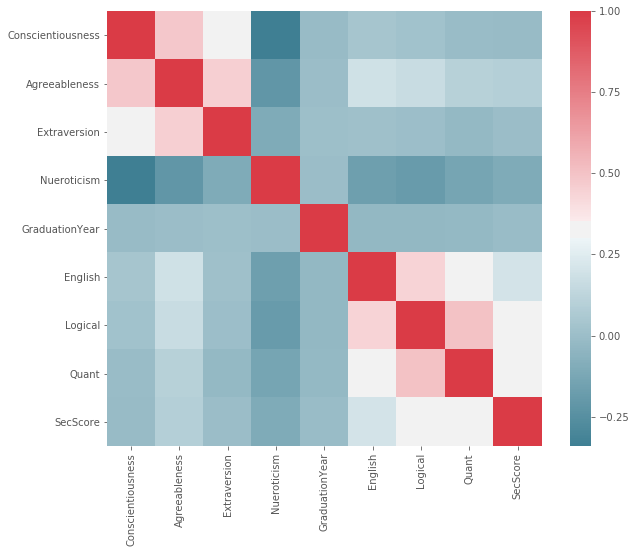

In [182]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))

corr = new_df_1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()


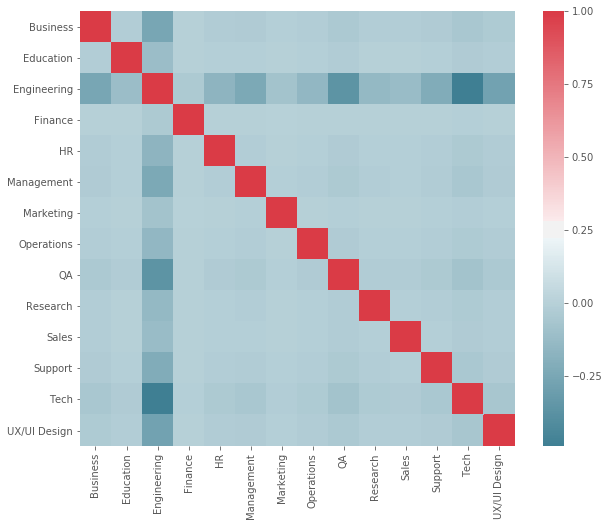

In [183]:
f, ax = plt.subplots(figsize=(10, 8))

corr = new_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()


### Does getting a graduate degree, help you get higher salaries at the same scores ?